In [1]:
from codecarbon import EmissionsTracker
# Iniciar el medidor
tracker = EmissionsTracker()
tracker.start()

[codecarbon INFO @ 01:00:35] [setup] RAM Tracking...
[codecarbon INFO @ 01:00:35] [setup] CPU Tracking...
[codecarbon WARNING @ 01:00:38] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 01:00:39] CPU Model on constant consumption mode: Apple M1
[codecarbon INFO @ 01:00:39] [setup] GPU Tracking...
[codecarbon INFO @ 01:00:39] No GPU found.
[codecarbon INFO @ 01:00:39] >>> Tracker's metadata:
[codecarbon INFO @ 01:00:39]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 01:00:39]   Python version: 3.9.12
[codecarbon INFO @ 01:00:39]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 01:00:39]   Available RAM : 8.000 GB
[codecarbon INFO @ 01:00:39]   CPU count: 8
[codecarbon INFO @ 01:00:39]   CPU model: Apple M1
[codecarbon INFO @ 01:00:39]   GPU count: None
[codecarbon INFO @ 01:00:39]   GPU model: None
[codecarbon INFO @ 01:00:42] Saving emissions data to

In [2]:
import torch
import matplotlib
import sklearn
import moviepy

In [3]:
import pandas as pd
import numpy as np

In [4]:
data = '/Users/lucia/.cache/kagglehub/datasets/bhoomikavalani/donateacrycorpusfeaturesdataset/versions/2/donateacry-corpus_features_final.csv'

df = pd.read_csv(data)

In [5]:
import re

def extraer_info_mejorada(ruta):
    # Extrae con regex el patrón típico del final del nombre del archivo
    match = re.search(r'-([\d.]+)-(m|f)-(\d+)-', ruta)
    if match:
        # match.groups() devuelve (edad_raw, genero, edad_clasificada)
        edad_raw, genero, edad = match.groups()
        return genero, edad
    else:
        return None, None  # si no encuentra patrón, deja como None

df[['Genero', 'Edad_Codigo']] = df['Cry_Audio_File'].apply(lambda x: pd.Series(extraer_info_mejorada(x)))

df['Genero'] = df['Genero'].map({'m': 0, 'f': 1})

edad_map = {
    '04': 1,
    '48': 2,
    '26': 3,
    '72': 4,
    '22': 5
}

df['Edad'] = df['Edad_Codigo'].map(edad_map)

df.drop(columns=['Cry_Audio_File', 'Edad_Codigo'], inplace=True)

In [6]:
import torch
from kan import *
import matplotlib.pyplot as plt
import moviepy.video.io.ImageSequenceClip

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cpu


In [7]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [8]:
# Definir columnas de entrada y la columna objetivo
feature_columns = df.columns[df.columns != 'Cry_Reason'].tolist()
target_column = 'Cry_Reason'

# Extraer datos y etiquetas
data = df[feature_columns].values
target = df[target_column].values

# Escalar los datos al rango [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)

# Convertir a tensores de PyTorch
data_tensor = torch.tensor(data, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.long)


# Dividir en conjunto de entrenamiento y test
train_data, test_data, train_target, test_target = train_test_split(
    data_tensor, target_tensor, test_size=0.2, random_state=42
)

# Crear DataLoaders
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_data, train_target), batch_size=1, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(test_data, test_target), batch_size=1, shuffle=False
)

# Inicializar tensores vacíos
train_inputs = torch.empty(0, len(feature_columns), device='cpu')
train_labels = torch.empty(0, dtype=torch.long, device='cpu')
test_inputs = torch.empty(0, len(feature_columns), device='cpu')
test_labels = torch.empty(0, dtype=torch.long, device='cpu')

# Concatenar datos del DataLoader
for data, labels in train_loader:
    train_inputs = torch.cat((train_inputs, data.to('cpu')), dim=0)
    train_labels = torch.cat((train_labels, labels.to('cpu')), dim=0)

for data, labels in test_loader:
    test_inputs = torch.cat((test_inputs, data.to('cpu')), dim=0)
    test_labels = torch.cat((test_labels, labels.to('cpu')), dim=0)

# Dataset final
dataset = {
    'train_input': train_inputs,
    'test_input': test_inputs,
    'train_label': train_labels,
    'test_label': test_labels
}

In [9]:

print("Train data shape: {}".format(dataset['train_input'].shape))
print("Train target shape: {}".format(dataset['train_label'].shape))
print("Test data shape: {}".format(dataset['test_input'].shape))
print("Test target shape: {}".format(dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([365, 27])
Train target shape: torch.Size([365])
Test data shape: torch.Size([92, 27])
Test target shape: torch.Size([92])


In [10]:
def print_example_data_point(dataset, feature_names):
    # Obtener un punto de ejemplo y su etiqueta
    example_data_point = dataset['train_input'][0]
    example_target = int(dataset['train_label'][0])

    print("\nExample Data Point:")
    for i, column_name in enumerate(feature_names):
        print(f"{column_name}: {example_data_point[i].item()}")

    print(f"\nTarget (numerical): {example_target}")

print_example_data_point(dataset, feature_columns)


Example Data Point:
Amplitude_Envelope_Mean: -0.7786297798156738
RMS_Mean: -0.819491446018219
ZCR_Mean: -0.9737029671669006
STFT_Mean: -0.8845059871673584
SC_Mean: -1.0
SBAN_Mean: -0.9518795013427734
SCON_Mean: -0.006329311057925224
MFCCs13Mean: 0.2880474627017975
delMFCCs13: 0.014563275501132011
del2MFCCs13: -0.10962922126054764
MelSpec: 0.4820563793182373
MFCCs20: 0.38777145743370056
MFCCs1: 0.42339998483657837
MFCCs2: -0.9684394598007202
MFCCs3: 0.6240072250366211
MFCCs4: 0.3037183880805969
MFCCs5: 0.08099161833524704
MFCCs6: 0.7531640529632568
MFCCs7: 0.3527826964855194
MFCCs8: -0.021927129477262497
MFCCs9: 0.5779638886451721
MFCCs10: -0.022207139059901237
MFCCs11: -0.2001076489686966
MFCCs12: 0.18545988202095032
MFCCs13: -0.06183459237217903
Genero: 1.0
Edad: -1.0

Target (numerical): 3


MODELO

In [11]:
print(f"Number of input features: {len(feature_columns)}")
print(f"Shape of train_input: {dataset['train_input'].shape}")

Number of input features: 27
Shape of train_input: torch.Size([365, 27])


checkpoint directory created: ./model
saving model version 0.0


[codecarbon INFO @ 01:00:57] Energy consumed for RAM : 0.000013 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 01:00:57] Energy consumed for all CPUs : 0.000021 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 01:00:57] 0.000033 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:01:12] Energy consumed for RAM : 0.000025 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 01:01:12] Energy consumed for all CPUs : 0.000042 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 01:01:12] 0.000067 kWh of electricity used since the beginning.


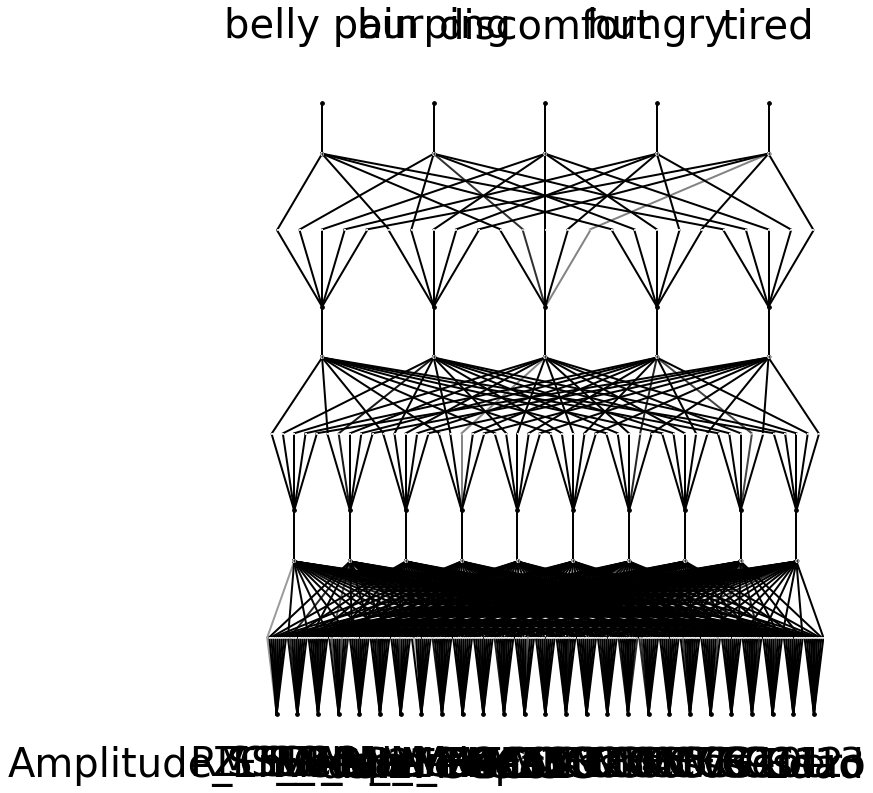

In [12]:
# Define el nombre de la carpeta para imágenes (si quieres guardar visualizaciones)
image_folder = 'video_img'

# Nombres de salida (clases de Cry_Reason)
out_classes = ['belly pain', 'burping', 'discomfort', 'hungry', 'tired']

# Define el modelo KAN con input size = nº de features y output size = nº de clases
model = KAN(
    width=[len(feature_columns), 10, 5, len(out_classes)],  # input -> hidden -> output
    grid=5,
    k=3,
    seed=0,
    device=device
)

# Forward pass para inicializar el modelo con los datos
model(dataset['train_input'])

# Visualizar la estructura del modelo
model.plot(
    beta=100,
    scale=1,
    in_vars=feature_columns,      # nombres de features (input)
    out_vars=out_classes          # nombres de clases (output)
)




In [13]:
print("Unique values in train_label:", torch.unique(dataset['train_label']))


Unique values in train_label: tensor([0, 1, 2, 3, 4])


In [14]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())
from sklearn.utils.class_weight import compute_class_weight

results = model.fit(dataset, opt="Adam", metrics=(train_acc, test_acc),
                      loss_fn=torch.nn.CrossEntropyLoss(), steps=8, lamb=0.01, lamb_entropy=10., save_fig=True, img_folder=image_folder)

description:   0%|                                                            | 0/8 [00:00<?, ?it/s][codecarbon INFO @ 01:01:27] Energy consumed for RAM : 0.000038 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 01:01:27] Energy consumed for all CPUs : 0.000063 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 01:01:27] 0.000100 kWh of electricity used since the beginning.
| train_loss: 1.26e+00 | test_loss: 1.84e+00 | reg: 8.82e+01 | :   0%|        | 0/8 [00:00<?, ?it/s][codecarbon INFO @ 01:01:42] Energy consumed for RAM : 0.000050 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 01:01:42] Energy consumed for all CPUs : 0.000083 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 01:01:42] 0.000133 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:01:57] Energy consumed for RAM : 0.000063 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 01:01:57] Energy consumed for all CPUs : 0.000104 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 01:01:57] 0.000167 kWh of electricity used since the beginni

saving model version 0.1


In [15]:
results['train_acc'][-1], results['test_acc'][-1]

(0.8493150472640991, 0.782608687877655)

[codecarbon INFO @ 01:06:57] Energy consumed for RAM : 0.000313 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 01:06:57] Energy consumed for all CPUs : 0.000521 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 01:06:57] 0.000833 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:07:17] Energy consumed for RAM : 0.000329 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 01:07:17] Energy consumed for all CPUs : 0.000548 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 01:07:17] 0.000877 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:07:32] Energy consumed for RAM : 0.000341 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 01:07:32] Energy consumed for all CPUs : 0.000569 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 01:07:32] 0.000910 kWh of electricity used since the beginning.


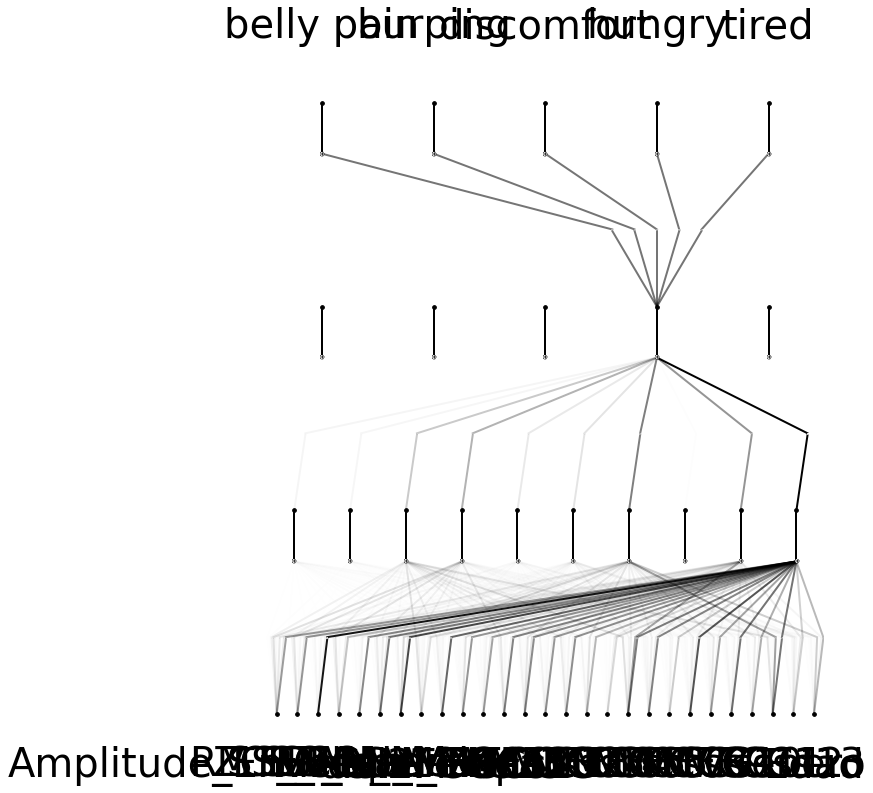

In [16]:
model.plot(
    scale=1,
    in_vars=feature_columns,  # Nombres dinámicos de los features
    out_vars=['belly pain', 'burping', 'discomfort', 'hungry', 'tired']  # Clases objetivo
)

In [17]:
video_name='video'
fps=10

fps = fps
files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4



Moviepy - Done !
Moviepy - video ready video.mp4


saving model version 0.2
Train Accuracy after pruning: 0.8493
Test Accuracy after pruning: 0.7826


[codecarbon INFO @ 01:07:47] Energy consumed for RAM : 0.000354 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 01:07:47] Energy consumed for all CPUs : 0.000590 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 01:07:47] 0.000943 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:08:02] Energy consumed for RAM : 0.000366 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 01:08:02] Energy consumed for all CPUs : 0.000611 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 01:08:02] 0.000977 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:08:17] Energy consumed for RAM : 0.000379 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 01:08:17] Energy consumed for all CPUs : 0.000631 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 01:08:17] 0.001010 kWh of electricity used since the beginning.


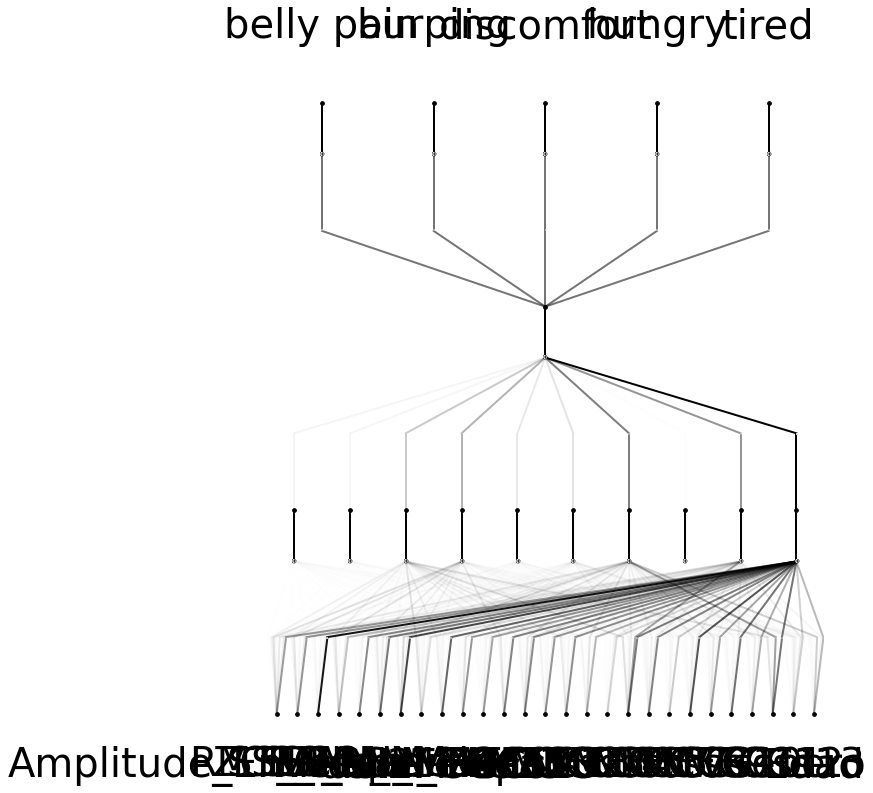

In [18]:
# Prune el modelo con umbrales suaves
model = model.prune(node_th=1e-4, edge_th=1e-4)

# Ejecutar el modelo podado en el dataset de Donate-a-Cry
model(dataset['train_input'])

# Accuracy en train y test después del pruning
def pruned_train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def pruned_test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

# Calcular accuracies
train_accuracy = pruned_train_acc()
test_accuracy = pruned_test_acc()

print(f"Train Accuracy after pruning: {train_accuracy:.4f}")
print(f"Test Accuracy after pruning: {test_accuracy:.4f}")

model.plot(
    scale=1,
    in_vars=feature_columns,
    out_vars=['belly pain', 'burping', 'discomfort', 'hungry', 'tired']
)


Prácticamente idéntico, lo que indica que los nodos y conexiones eliminados no aportaban valor significativo. Tu modelo sigue entendiendo bien los datos, pero ahora es más ligero y posiblemente más interpretable y generalizable.

In [19]:
# Revisar si hay NaN o valores infinitos en las predicciones del modelo pruneado
pruned_output = model(dataset['train_input'])

if torch.isnan(pruned_output).any() or torch.isinf(pruned_output).any():
    print("⚠️ Hay valores NaN o Inf en las predicciones del modelo después de pruning.")
else:
    print("✅ No hay NaN ni Inf en las predicciones del modelo.")

✅ No hay NaN ni Inf en las predicciones del modelo.


[codecarbon INFO @ 01:08:32] Energy consumed for RAM : 0.000391 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 01:08:32] Energy consumed for all CPUs : 0.000652 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 01:08:32] 0.001043 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:08:47] Energy consumed for RAM : 0.000404 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 01:08:47] Energy consumed for all CPUs : 0.000673 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 01:08:47] 0.001077 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:08:47] 0.000456 g.CO2eq/s mean an estimation of 14.371679599373158 kg.CO2eq/year


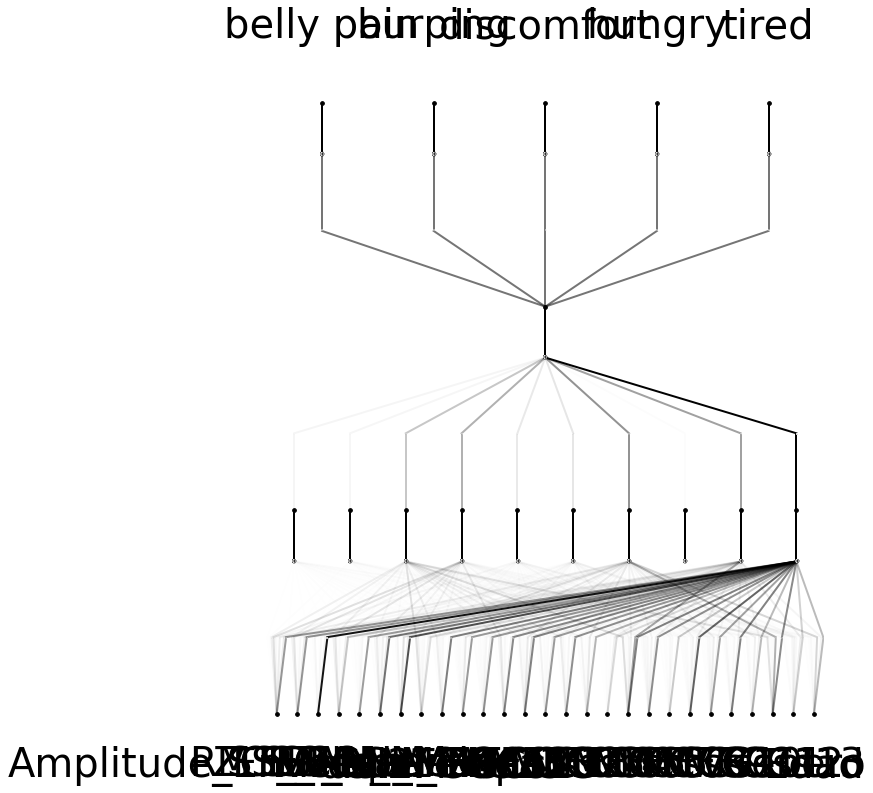

In [20]:
model.plot(
    scale=1,
    in_vars=feature_columns,
    out_vars=['belly pain', 'burping', 'discomfort', 'hungry', 'tired']
)


In [21]:
from sklearn.metrics import classification_report

# Obtener predicciones del modelo en el conjunto de test
y_pred = torch.argmax(model(dataset['test_input']), dim=1).cpu().numpy()
y_true = dataset['test_label'].cpu().numpy()

# Generar el reporte de clasificación
report = classification_report(y_true, y_pred, target_names=['belly pain', 'burping', 'discomfort', 'hungry', 'tired'])

# Mostrar métricas de sensibilidad (recall) y F1-score
print(report)

              precision    recall  f1-score   support

  belly pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.78      1.00      0.88        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.78        92
   macro avg       0.16      0.20      0.18        92
weighted avg       0.61      0.78      0.69        92



/Users/lucia/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucia/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucia/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Obtener predicciones del modelo
y_logits = model(dataset['test_input']).detach().cpu().numpy()
y_true = dataset['test_label'].cpu().numpy()

# Binarizar etiquetas reales (one-hot)
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])  # tus clases

# Calcular AUC-ROC para todas las clases (promedio macro)
auc = roc_auc_score(y_true_bin, y_logits, average='macro', multi_class='ovr')

print(f"Multiclass AUC-ROC (macro average): {auc:.4f}")


Multiclass AUC-ROC (macro average): 0.4660


In [23]:
# Detener el medidor y obtener los resultados
tracker.stop()

[codecarbon INFO @ 01:08:52] Energy consumed for RAM : 0.000408 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 01:08:52] Energy consumed for all CPUs : 0.000681 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 01:08:52] 0.001089 kWh of electricity used since the beginning.


0.00022347352055558545